<a href="https://colab.research.google.com/github/jmhuer/quantum_dots/blob/main/quantum_dots_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data from excell


In [1]:
!pip install skorch
!pip install tqdm
!git clone https://github.com/jmhuer/optimization_tools

from optimization_tools.utils import download_gdrive
data = '14mee8d0GDbwNzIprVSJoWdojGtqO_aTX' ##google drive id of excell 
download_gdrive(data)

     |████████████████████████████████| 133kB 4.3MB/s 
Cloning into 'optimization_tools'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 46 (delta 12), reused 39 (delta 8), pack-reused 0
Unpacking objects: 100% (46/46), done.
Downloading...
From: https://drive.google.com/uc?id=14mee8d0GDbwNzIprVSJoWdojGtqO_aTX
To: /content/QDots data - Juan.xlsx
100%|##########| 39.7k/39.7k [00:00<00:00, 14.2MB/s]



In [2]:
import pandas as pd

def open_excel(filename):
    excell = pd.ExcelFile(filename)
    excell.sheet_names
    df = excell.parse("Sheet1")
    df.columns = df.columns.map(str)
    df = df.dropna().reset_index(drop=True)
    return df

df = open_excel("/content/QDots data - Juan.xlsx")

In [3]:
df.head()

,Unnamed: 0,Time (min),μL,nM λ1,nM λ2,λ1 (nm),λ2 (nm),# emitters λ1 (x1010),# emitters λ2 (x1010),415,445,480,515,555,590,630,680
0,2021-04-12,0.0,0.0,0.0,0.0,620.0,560.0,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0
1,2021-04-12,0.0,30.0,50.0,0.0,620.0,560.0,90.3321,0.0,9.0,20.0,21.0,67.0,106.0,666.0,4320.0,24.0
2,2021-04-12,1.0,30.0,50.0,0.0,620.0,560.0,90.3321,0.0,9.0,21.0,22.0,69.0,107.0,675.0,4413.0,25.0
3,2021-04-12,2.0,30.0,50.0,0.0,620.0,560.0,90.3321,0.0,9.0,21.0,22.0,69.0,107.0,677.0,4439.0,25.0
4,2021-04-12,3.0,30.0,50.0,0.0,620.0,560.0,90.3321,0.0,9.0,21.0,22.0,69.0,106.0,678.0,4457.0,25.0


# Ploting utils

In [4]:
import plotly.graph_objects as graph
def plot(all_history:list, title:str, log = False):
    """
    input:
        all_history: list of dicts to plot
    ret:
        None: show plotly fig
    """
    symbol_sequence= ['circle-open', 'circle', 'circle-open-dot', 'square']
    fig = graph.Figure(layout = graph.Layout(title=graph.layout.Title(text=title))) 
    for i in range(len(all_history)):
        fig.add_trace(graph.Scatter(x = all_history[i]["x"], 
                                    y = all_history[i]["y"],
                                    name = all_history[i]["legend"],
                                    mode='markers',
                                    marker_size=5,
                                    marker_symbol=all_history[i]["marker_symbol"])) 
    if log: fig.update_xaxes(type="log")
    fig.show()

def plotline(all_history:list, title:str, log = False):
    """
    input:
        all_history: list of dicts to plot
    ret:
        None: show plotly fig
    """
    fig = graph.Figure(layout = graph.Layout(title=graph.layout.Title(text=title))) 
    for i in range(len(all_history)):
        fig.add_trace(graph.Scatter(x = all_history[i]["x"], 
                                    y = all_history[i]["y"],
                                    name = all_history[i]["legend"])) 
    if log: fig.update_xaxes(type="log")
    fig.show()

## Pre-processing + model defenitions before training

In [5]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
X_columns  = ["415","445","480", "515", "555", "590", "630", "680"]
Y1_columns = ["# emitters λ1 (x1010)"]
Y2_columns = ["# emitters λ2 (x1010)"]
Y_columns  = ["# emitters λ1 (x1010)", "# emitters λ2 (x1010)"]

row = 14

X_train, X_test = df.loc[row, X_columns], df.loc[row, X_columns]
Y_train, Y_test = df.loc[row, Y2_columns], df.loc[row, Y2_columns]
Y_train_both, Y_test_both = df.loc[row, Y_columns], df.loc[row, Y_columns]
wavelenght = list(map(int, list(X_train.keys())))

current_plot = {"legend": "predictions", 
                "x": wavelenght, 
                "y": X_train.values,
                "marker_symbol": 'square'}

## fit guassian process 
gp_feature =  GaussianProcessRegressor(RBF() , n_restarts_optimizer=100, normalize_y=False)
#pre-process data
X_data = np.split(np.array(wavelenght), len(wavelenght))
gp_feature.fit(X_data, X_train.values)

##predict continiously
x = np.atleast_2d(np.linspace(min(wavelenght), max(wavelenght), 1000)).T
y_pred, sigma = gp_feature.predict(x, return_std=True)

pred_plot = {"legend": "predictions", 
                "x": x.ravel(), 
                "y": y_pred,
                "marker_symbol": 'circle-open'}

plot([current_plot, pred_plot], "interpolated wavelength")

print(gp_feature.get_params)

<bound method BaseEstimator.get_params of GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=RBF(length_scale=1), n_restarts_optimizer=100,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)>


mu1: [630.] 	 mu2: [570.41991983]


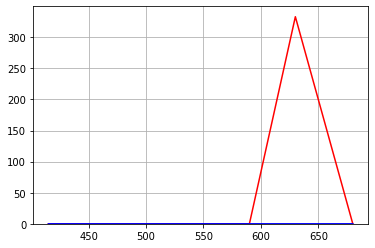

In [6]:
from sklearn.mixture import GaussianMixture
import numpy as np

X_data = np.split(np.array(wavelenght), len(wavelenght))
new_X_data = [a*b for a,b in zip(X_data, X_train.values)]
l = []
for a,b in zip(X_data, X_train.values):
    l.extend([a]*(int(b)+1))
f = np.array(l)
g = GaussianMixture(n_components=2, random_state=0).fit(l)

from matplotlib import rc
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.ticker as tkr
import scipy.stats as stats

weights = g.weights_
means = g.means_
covars = g.covariances_
print("mu1: {} \t mu2: {}".format(means[0] , means[1]))
plt.hist(f, bins=10, histtype='bar', density=True, ec='red', alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red')
plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='blue')

plt.rcParams['agg.path.chunksize'] = 10

plt.grid()
plt.show()


# x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

# pred_plot = {"legend": "predictions", 
#                 "x": f_axis, 
#                 "y": weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel()*100,
#                 "marker_symbol": 'circle-open'}

# plotline([ pred_plot, current_plot], "interpolated wavelength")

In [7]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel 
from sklearn.gaussian_process import GaussianProcessRegressor


##LINEAR REGRESSION
lr_reg = make_pipeline(LinearRegression())

##RandomForestRegressor
rf_reg = make_pipeline(StandardScaler(), RandomForestRegressor())
parameters = {'randomforestregressor__max_depth':[1,2,3,4,5]}
rf_reg = GridSearchCV(rf_reg, parameters)
  
##SVM
svr = make_pipeline(StandardScaler(), SVR(kernel='linear'))
parameters = {'svr__kernel':['linear', 'rbf'], 'svr__epsilon':[0.1, 0.2, 0.3,0.6], 'svr__C': [0.1,0.5,1,2,3]}
svr = GridSearchCV(svr, parameters)

##guassian process 
# Instantiate a Gaussian Process model
gp = make_pipeline(StandardScaler(), GaussianProcessRegressor( n_restarts_optimizer=20, normalize_y=True, copy_X_train=False))
parameters = {'gaussianprocessregressor__kernel':[RBF() + RBF(), 
                                                  ]}
gp = GridSearchCV(gp, parameters)



# NN stuff here

In [8]:
from torch import nn
from skorch import NeuralNetRegressor

class MultivariateLinearRegression(nn.Module):
    def __init__(self, input = 8, output=1, num_units=10, nonlin=nn.LeakyReLU()):
          super(MultivariateLinearRegression, self).__init__()
          self.dense0 = nn.Linear(input, num_units)
          self.nonlin = nonlin
          self.dropout = nn.Dropout(0.1)
          self.output = nn.Linear(num_units, output)
    def forward(self, X):
          X = self.nonlin(self.dense0(X))
          X = self.dropout(X)
          X = self.output(X)
          return X




## single variable 
net = NeuralNetRegressor(
    MultivariateLinearRegression().double(),
    iterator_train__shuffle = False,
    train_split = False,
    verbose = 0)

myNN_reg = make_pipeline(StandardScaler(), net)

params = {
    'neuralnetregressor__lr': [0.001, 0.002, 0.003],
    'neuralnetregressor__max_epochs': [10, 20, 30]
}
myNN_reg = GridSearchCV(myNN_reg, params)




## multivariate variable 
net2 = NeuralNetRegressor(
    MultivariateLinearRegression(output=2).double(),
    iterator_train__shuffle = False,
    train_split = False,
    verbose = 0)

myNN_reg2 = make_pipeline(StandardScaler(), net2)

params = {
    'neuralnetregressor__lr': [0.001, 0.002, 0.003],
    'neuralnetregressor__max_epochs': [10, 20, 30]
}
myNN_reg2 = GridSearchCV(myNN_reg2, params)


# overfit criteria 

In [9]:
# calculate aic for regression
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic


# calculate bic for regression
def calculate_bic(n, mse, num_params):
	bic = n * log(mse) + num_params * log(n)
	return bic

##Training loop w/ cross-validation 

In [10]:
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

##function to help store history and metrics of each cross validation run
history = dict()
def append_history(history, algorithm, name, X_test, Y_test):
    #calculate performance metrics
    Y_pred = algorithm.predict(X_test)
    score = algorithm.score(X_test, Y_test)
    #if dict does not contain current alg, create a key
    if name not in history.keys(): 
        history[name] = {"mse": [], "r2": [], "sigmas":[], "predictions": [], "actual": []}
    #store preformance metrics & history
    mse = mean_squared_error(Y_test, Y_pred)
    history[name]["mse"].append(mse)
    history[name]["r2"].append(score)
    history[name]["predictions"].append(Y_pred)
    history[name]["actual"].append(Y_test)
    if name == "GP_reg":  
        _, sigma = algorithm.best_estimator_[1].predict(X_test, return_std=True)
        history[name]["sigmas"].append(sigma)
    return history



X_columns  = ["415","445","480", "515", "555", "590", "630", "680"]
Y1_columns = ["# emitters λ1 (x1010)"]
Y2_columns = ["# emitters λ2 (x1010)"]
Y_columns  = ["# emitters λ1 (x1010)", "# emitters λ2 (x1010)"]


##For Cross validations 
n_splits = 10
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True) # Define the split - into 10 folds 

##A progress bar because Im fancy
pbar = tqdm(total=100,position=0, leave=True)

##MAIN LOOP
for train_index, test_index in kf.split(df):
    X_train, X_test = df.loc[train_index, X_columns], df.loc[test_index, X_columns]
    Y_train, Y_test = df.loc[train_index, Y2_columns], df.loc[test_index, Y2_columns]
    Y_train_both, Y_test_both = df.loc[train_index, Y_columns], df.loc[test_index, Y_columns]

    ### Gaussian process regression 
    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X_train, Y_train.values)
    history = append_history(history, gp, "GP_reg", X_test, Y_test)

    ##NN Regressor multivariate
    myNN_reg2.fit(X_train, Y_train_both.values)
    history = append_history(history, myNN_reg2, "myNN_reg2", X_test, Y_test_both)
    
    ##LINEAR REGRESSION
    lr_reg.fit(X_train, Y_train.values.ravel())
    history = append_history(history, lr_reg, "linear_regression", X_test, Y_test)

    ##RandomForestRegressor
    rf_reg.fit(X_train, Y_train.values.ravel())
    history = append_history(history, rf_reg, "rf_reg", X_test, Y_test)

    ##Support Vecotor Regressor 
    svr.fit(X_train, Y_train.values.ravel())
    history = append_history(history, svr, "svr", X_test, Y_test)

    # ##NN Regressor
    myNN_reg.fit(X_train, Y_train.values)
    history = append_history(history, myNN_reg, "myNN_reg", X_test, Y_test)



    pbar.update(10)
pbar.close()

print('\n')
for i in history.keys():
    print('\n', i," : ", sum(history[i]["mse"]) / len(history[i]["mse"]))
    print("---")


# num_params = len(gp.best_estimator_[1].coef_) + 1
# print(calculate_bic(len(Y_test), history["linear_regression"]["mse"], num_params))

# print(gp.params)

100%|██████████| 100/100 [05:50<00:00,  3.50s/it]




 GP_reg  :  8.863405537459457
---

 myNN_reg2  :  18.471421950102513
---

 linear_regression  :  3.533323019286695
---

 rf_reg  :  1.1505184452383395
---

 svr  :  4.083087092195877
---

 myNN_reg  :  8.808756479683812
---


In [11]:
gp.best_estimator_[1]

GaussianProcessRegressor(alpha=1e-10, copy_X_train=False,
                         kernel=RBF(length_scale=1) + RBF(length_scale=1),
                         n_restarts_optimizer=20, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [12]:
print('\n')
for i in history.keys():
    print('\n', i," : ", sum(history[i]["r2"]) / len(history[i]["r2"]))
    print("---")




 GP_reg  :  0.9883167728750493
---

 myNN_reg2  :  0.9759043487543886
---

 linear_regression  :  0.9952320133708717
---

 rf_reg  :  0.9985580569375108
---

 svr  :  0.9946020805224178
---

 myNN_reg  :  0.9881039783571264
---


# Plot each CV split validation on same plot predicted vs actual

In [13]:
import numpy as np
names = list(history.keys())

n_splits = 10

#perfect plot
perfect_plot = {"legend": "actuals", 
                "x": list(np.linspace(0, 100, num=1000, endpoint=True)), 
                "y": list(np.linspace(0, 100, num=1000, endpoint=True)),
                "marker_symbol": 'line-ne-open'}
X,Y = [], []           
for alg in names:
  for i in range(n_splits):
      X = X + list(history[alg]["actual"][i].values.ravel())
      Y = Y + list(history[alg]["predictions"][i].ravel())

  current_plot = {"legend": "predictions", 
                  "x": X, 
                  "y": Y,
                  "marker_symbol": 'star'}

  plot([current_plot, perfect_plot], alg + " predicted v actual")

In [14]:

# # print("sigma", sigma.shape)

# lower = np.multiply(y_pred.ravel() - 1.9600 ,sigma)
# upper = np.multiply(y_pred.ravel() + 1.9600 , sigma)
# # print("lower",lower.shape)


def top(X,Y):
  topX, topY = [],[]
  for a,b in zip(X,Y):
    if a not in topX:
      topX.append(a)
      topY.append(b)
    elif topY[topX.index(a)] < b:
      topY[topX.index(a)] = b 
  return topX, topY
     
def low(X,Y):
  topX, topY = [],[]
  for a,b in zip(X,Y):
    if a not in topX:
      topX.append(a)
      topY.append(b)
    elif topY[topX.index(a)] > b:
      topY[topX.index(a)] = b 
  return topX, topY


import numpy as np
names = list(history.keys())

n_splits = 10

#perfect plot
perfect_plot = {"legend": "actuals", 
                "x": list(np.linspace(0, 100, num=1000, endpoint=True)), 
                "y": list(np.linspace(0, 100, num=1000, endpoint=True)),
                "marker_symbol": 'line-ne-open'}
X,Y,lower,high = [], [], [], []              
for alg in names:
  for i in range(n_splits):
      X = X + list(history[alg]["actual"][i].values.ravel())
      Y = Y + list(history[alg]["predictions"][i].ravel())
      sigma = history[alg]["sigmas"][i].ravel()
      lower = lower + list(history[alg]["predictions"][i].ravel() - 1.9600*sigma)
      high = high + list(history[alg]["predictions"][i].ravel() + 1.9600*sigma)


  current_plot = {"legend": "predictions", 
                  "x": X, 
                  "y": Y,
                  "marker_symbol": 'star'}

  # #confidence plot
  low_X, low_Y = low(X,lower)
  # lowconfidence_plot = {"legend": "95% confidence", 
  #                       "x": low_X, 
  #                       "y": low_Y,
  #                       "marker_symbol": 'square'}

  top_X, top_Y = top(X,high)
  low_X.extend(top_X)
  low_Y.extend(top_Y)
  highconfidence_plot = {"legend": "95% confidence", 
                        "x": low_X, 
                        "y": low_Y,
                        "marker_symbol": 'square'}

  plot([current_plot, perfect_plot,highconfidence_plot], alg + " predicted v actual")



IndexError: ignored

In [132]:
# from scipy.spatial import ConvexHull
# import numpy as np

# def point_in_hull(p, hull):
#     """
#     Test if points in `p` are in `hull`

#     `p` should be a `NxK` coordinates of `N` points in `K` dimensions
#     `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
#     coordinates of `M` points in `K`dimensions for which Delaunay triangulation
#     will be computed
#     """
#     from scipy.spatial import Delaunay
#     if not isinstance(hull,Delaunay):
#         hull = Delaunay(hull)

#     return hull.find_simplex(p)>=0
# random_points = np.random.uniform(0,600, (X_train.shape[0]*1000,X_train.shape[1]))
# print(random_points.shape)
# # hull = ConvexHull(X_train)
# inHull = []
# # for p in random_points:
# print(point_in_hull(X_train[0:1].T*0.5 + X_train[10:11].T*0.5, X_train))
# point_is_in_hull.append(X_train[0:1]*0.5 + X_train[10:11]*0.5)
# print(p.shape)





# matr = np.random.uniform(0,4929*11001, (X_train.shape[0]*10000,X_train.shape[1]))

# print(X_train.max())

matr = np.linspace((0,0,0,0,0,0,0,0),
                   (X_train["415"].max(),
                    X_train["445"].max(),
                    X_train["480"].max(),
                    X_train["515"].max(),
                    X_train["555"].max(),
                    X_train["590"].max(),
                    X_train["630"].max(),
                    X_train["680"].max()),100000)


print("inHull.shape " ,matr.max())

y_pred = gp.predict(matr)
print("ypred" ,y_pred.ravel().max())


inHull.shape  4929.0
ypred 78.93812408881871


In [182]:
import numpy as np
import matplotlib.pyplot as pt

X_columns  = ["415","445","480", "515", "555", "590", "630", "680"]
Y1_columns = ["# emitters λ1 (x1010)"]
Y2_columns = ["# emitters λ2 (x1010)"]
Y_columns  = ["# emitters λ1 (x1010)", "# emitters λ2 (x1010)"]


def convex_combination(df, number_points2combine):
    ar = np.arange(len(df))
    np.random.shuffle(ar) 
    vecs = df.loc[ar[0:number_points2combine], X_columns]
    print("tset", ar[0:number_points2combine])

    vecs = vecs.T
    dim, n_vectors =  vecs.shape
    n_coeffs = n_vectors
    # Random numbers between 0 and 1. Don't confuse with randn.
    coeffs = np.random.rand(n_coeffs, 30000)
    sum_of_first_two = np.sum(coeffs[:2], axis=0)
    coeffs[2] = 1-sum_of_first_two # (*)

    # First two coefficients guaranteed to be positive
    # Third coefficcient could be negative
    # All coefficients guaranteed to add up to one because of (*)
    good_coeffs = coeffs[2] >= 0
    # print(good_coeffs)
    coeffs = coeffs[:, good_coeffs]
    n_combinations = coeffs.shape[-1]
    combinations = np.einsum("ji,kj->ki", coeffs, vecs)
    return combinations.T


X_synth = convex_combination(df = df, number_points2combine=10)

y_pred = gp.predict(X_synth)
print("ypred" ,list(y_pred.ravel()))
#perfect plot
vals = list(np.sort(y_pred.ravel()))
pplot = {"legend": "actuals", 
         "x": [i for i in range(len(vals))], 
         "y": vals,
         "marker_symbol": 'line-ne-open'}
plotline([pplot], "test")

tset [283 302 172  68 262 165 106 279 272 214]
ypred [84.1198045795205, 78.2350074638649, 60.71197707205834, 74.9612234283275, 79.41860991494738, 66.98522567968045, 83.45933264256018, 63.431209301337866, 40.95954391244037, 80.42204381973148, 80.29716378842816, 65.8802580240703, 64.93362080351538, 33.91005899424021, 52.40490379903301, 81.41712065191075, 65.37876305413366, 72.71804079323556, 58.82912620958224, 62.917277783011606, 35.35193355755662, 74.63627530861896, 52.99539116974103, 37.01049765164271, 75.17276010484926, 69.53131244805793, 39.24328991428015, 47.575645410249216, 78.79011205283632, 81.62135062280163, 81.97675294546855, 68.29438854567353, 85.259864363524, 65.36635752061926, 53.40944605835187, 46.28822917467562, 70.11962657076575, 80.04285633750143, 82.09130155271771, 71.10951243939843, 85.91310473671649, 66.68608794328307, 59.61704061711582, 78.55247696179696, 43.28619205135735, 80.72664566676802, 36.46445405369894, 77.33175169178627, 83.9848487583689, 48.88487593935479, 